In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`
 
  * Aggregated Camera Counts for NYC Census Tracts: `../Data/NYC_tracts_camera_aggregates.csv`


 **Shapefiles**

 * NYC Building Footprint: https://data.cityofnewyork.us/resource/7w4b-tj9d.json

#### Output Files:

In [2]:
#read camera datasets
am_int = gpd.read_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp', index_col = 0)
hik = gpd.read_file('../Data/hikvision/hikvision_camera_brooklyn.shp', index_col = 0)

In [3]:
am_int.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_dom_1,type_bul_1,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,geometry
0,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663)
1,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983)
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289)
3,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276)
4,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540)


In [4]:
am_int.columns

Index(['PanoramaId', 'n_cameras_', 'attached_s', 'attached_b', 'attached_u',
       'type_dome_', 'type_bulle', 'type_unkno', 'n_camera_1', 'attached_1',
       'attached_2', 'attached_3', 'type_dom_1', 'type_bul_1', 'type_unk_1',
       'Lat', 'Long', 'geometry_p', 'BoroName', 'URL', 'ImageDate',
       'geometry'],
      dtype='object')

In [5]:
print(len(am_int))
am_int = am_int[am_int['n_cameras_']> 0]
print(len(am_int))

10377
4662


In [6]:
#combine both dataframes into one
# create a new dataframe with the desired columns
camera_locs = gpd.GeoDataFrame(columns=['Data_Source', 'Camera_Count', 'geometry'],crs = 4326)
am_int['Data_Source'] = 'Amnesty'
hik['Data_Source'] = 'Hikvision'
hik['Camera_Count'] = 1

# add the geometries and camera counts from amn_int_buff_200
camera_locs = pd.concat([camera_locs,am_int[['Data_Source','n_cameras_', 'geometry']].rename(columns={'n_cameras_': 'Camera_Count'})])

# add the geometries and camera counts from hik_buff_200, setting the camera count to 1
camera_locs = pd.concat([camera_locs,hik[['Data_Source','Camera_Count', 'geometry']]])

# reset the index of the new geodataframe
camera_locs = camera_locs.reset_index(drop=True)
camera_locs.head()

,Data_Source,Camera_Count,geometry
0,Amnesty,5,POINT (-73.95673 40.69289)
1,Amnesty,5,POINT (-73.97285 40.62937)
2,Amnesty,1,POINT (-73.96565 40.70615)
3,Amnesty,7,POINT (-73.90359 40.67201)
4,Amnesty,1,POINT (-73.95976 40.67575)


In [7]:
## create buffer zone around camera point locations
#add 200m around each shape
camera_locs = camera_locs.to_crs('EPSG:32118') # Use an appropriate projected system for your area
camera_locs['buffer_distance'] = 200 # in meters
buffered_gdf = pd.DataFrame()

for index, row in camera_locs.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = pd.concat([buffered_gdf, pd.DataFrame({'geometry': [buffered_polygon]})])

buffered_gdf = buffered_gdf.reset_index(drop=True)
camera_locs_buff = gpd.GeoDataFrame(buffered_gdf,crs = camera_locs.crs)
camera_locs_buff = camera_locs_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [8]:
camera_locs_buff = pd.merge(camera_locs.drop(columns=['geometry']),camera_locs_buff, left_index=True, right_index=True)
camera_locs_buff = gpd.GeoDataFrame(camera_locs_buff,geometry = 'geometry', crs = 'EPSG:4326')
camera_locs_buff.head()

,Data_Source,Camera_Count,buffer_distance,geometry
0,Amnesty,5,200,"POLYGON ((-73.95437 40.69289, -73.95438 40.692..."
1,Amnesty,5,200,"POLYGON ((-73.97049 40.62937, -73.97050 40.629..."
2,Amnesty,1,200,"POLYGON ((-73.96329 40.70615, -73.96330 40.705..."
3,Amnesty,7,200,"POLYGON ((-73.90122 40.67201, -73.90124 40.671..."
4,Amnesty,1,200,"POLYGON ((-73.95739 40.67575, -73.95740 40.675..."


In [9]:
if not os.path.exists('../Data/all_camera_locs_200m_buff'):
    os.makedirs('../Data/all_camera_locs_200m_buff')
    print("Directory created successfully")
else:
    print("Directory already exists")
camera_locs_buff.to_file('../Data/all_camera_locs_200m_buff/all_camera_locs_200m_buff.shp')

Directory already exists


# Lets clip the buffer zones to the obstructing building/block boundaries as calculated in the previous script `03_cityblock_convex_hull`

In [13]:
blk_bndry = gpd.read_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')
blk_bndry.head()

,index,geometry
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703..."
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703..."
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703..."
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702..."
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702..."


In [14]:
len(blk_bndry)

19969

<Axes: >

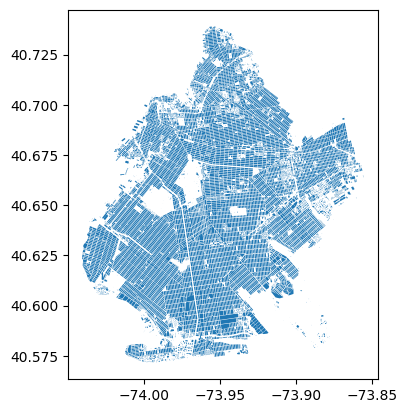

In [15]:
blk_bndry.plot()

In [17]:
blk_bndry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
#load boundary file
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
#clip to bk boundary extent to remove the camera area outside of boundary
camera_buff_200_clipped = camera_locs_buff.clip(bk_bndry)

In [21]:
##lets take the difference of the 200m buffer geometry in comparison to the Brooklyn MapPLUTO geometry
# Calculate the difference between the two GeoDataFrames
street_surv_area = gpd.overlay(camera_buff_200_clipped, blk_bndry, how='difference')

In [22]:
street_surv_area.head()

,Data_Source,Camera_Count,buffer_distance,geometry
0,Amnesty,1,200,"POLYGON ((-73.99823 40.57120, -73.99842 40.571..."
1,Amnesty,3,200,"POLYGON ((-73.99757 40.57134, -73.99774 40.571..."
2,Amnesty,3,200,"POLYGON ((-74.00003 40.57107, -74.00024 40.571..."
3,Hikvision,1,200,"POLYGON ((-73.99800 40.57138, -73.99817 40.571..."
4,Amnesty,1,200,"POLYGON ((-73.99944 40.57132, -73.99963 40.571..."


Text(0.5, 1.0, 'Amnesty International Camera Buffer Zones Building Footprint Clip (200m)')

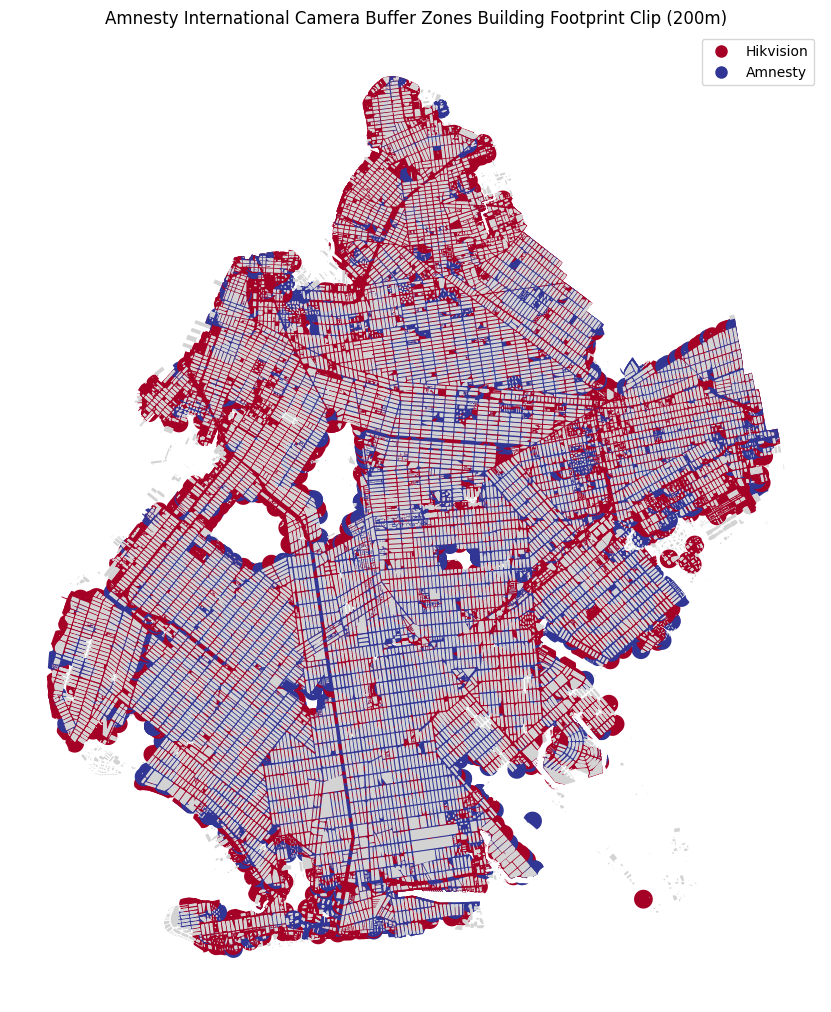

In [24]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Hikvision', 'B': 'Amnesty'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
street_surv_area.plot(column='Data_Source', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
blk_bndry.plot(ax = ax, color = 'lightgrey')
plt.axis('off')
plt.tight_layout()
plt.title('Amnesty International Camera Buffer Zones Building Footprint Clip (200m)')
# plt.savefig('../Outputs/MapPLUTO_Clipped_AmnInternation_BK_CameraBuffer_200m.png')

### Follow up Questions for Team 4/11:

1. How do we want to account for multiple cameras in same intersection/location in our metric calculation?
    * add area for each camera regardless of location overlap?
    
    
2. How can we ensure the cameras within the Hikvision dataset are not the same as any camera in the amnesty international dataset?

In [25]:
#meter projection
street_surv_area = street_surv_area.to_crs(32118)
street_surv_area['area_km2'] = street_surv_area.geometry.area / 1e6
street_surv_area['area_cum'] = street_surv_area['area_km2']*street_surv_area['Camera_Count']
#re-project
street_surv_area = street_surv_area.to_crs(4326)
street_surv_area.head()

,Data_Source,Camera_Count,buffer_distance,geometry,area_km2,area_cum
0,Amnesty,1,200,"POLYGON ((-73.99823 40.57120, -73.99842 40.571...",0.105202,0.105202
1,Amnesty,3,200,"POLYGON ((-73.99757 40.57134, -73.99774 40.571...",0.099639,0.298916
2,Amnesty,3,200,"POLYGON ((-74.00003 40.57107, -74.00024 40.571...",0.108102,0.324305
3,Hikvision,1,200,"POLYGON ((-73.99800 40.57138, -73.99817 40.571...",0.103569,0.103569
4,Amnesty,1,200,"POLYGON ((-73.99944 40.57132, -73.99963 40.571...",0.110247,0.110247


In [26]:
#aggregate to NTA level for now
bk_ntas = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

In [27]:
#calculate the entire NTA Area
bk_ntas = bk_ntas.to_crs(32118)
bk_ntas['NTA_area_km2'] = bk_ntas.geometry.area / 1e6
bk_ntas = bk_ntas.to_crs(4326)
bk_ntas.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,NTA_area_km2
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",7.626437
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",1.531316
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((-73.90321 40.67874, -73.90256 40.678...",1.866427
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((-73.93754 40.60856, -73.93830 40.608...",2.543625


In [37]:
bk_ntas.dtypes

boro_code        float64
boro_name         object
county_fip        object
ntacode           object
ntaname           object
shape_area       float64
shape_leng       float64
geometry        geometry
NTA_area_km2     float64
dtype: object

In [37]:
# # Reproject to a projected coordinate system that uses meters instead of degrees
bk_ntas = bk_ntas.to_crs(4326)

# Spatial join
joined = gpd.sjoin(blk_bndry, bk_ntas, how="inner", predicate="within")

In [38]:
joined.head()

,index,geometry,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,NTA_area_km2
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607


In [39]:
#calculate the building-block Area
joined = joined.to_crs(32118)
joined['block_area_km2'] = joined.geometry.area / 1e6
joined = joined.to_crs(4326)
joined.head()

,index,geometry,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,NTA_area_km2,block_area_km2
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607,0.007936
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607,0.003720
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607,0.002866
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607,0.007150
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702...",45,3.0,Brooklyn,047,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.847694e+07,32542.664431,2.645607,0.008566


In [44]:
# Group by neighborhood and sum the areas
area_by_neighborhood = joined[['ntacode','block_area_km2']].groupby(['ntacode']).sum().reset_index()
area_by_neighborhood.sort_values(by = 'block_area_km2', ascending = False).head(10)

,ntacode,block_area_km2
41,BK82,3.642047
25,BK50,3.216950
44,BK88,3.103180
23,BK45,2.986630
1,BK17,2.985185
26,BK58,2.918297
11,BK31,2.864698
8,BK28,2.719738
28,BK61,2.714752
20,BK42,2.529854


In [42]:
nta_surv = gpd.sjoin(bk_ntas,street_surv_area, how = 'left',predicate = 'contains')
nta_surv.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,NTA_area_km2,index_right,Data_Source,Camera_Count,buffer_distance,area_km2,area_cum
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3647,Amnesty,1,200,0.062062,0.062062
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3660,Hikvision,1,200,0.070566,0.070566
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3649,Hikvision,1,200,0.070566,0.070566
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3662,Hikvision,1,200,0.070566,0.070566
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3661,Hikvision,1,200,0.070566,0.070566


In [43]:
nta_surv.columns

Index(['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'geometry', 'NTA_area_km2', 'index_right',
       'Data_Source', 'Camera_Count', 'buffer_distance', 'area_km2',
       'area_cum'],
      dtype='object')

In [61]:
nta_agg = nta_surv.groupby(by = ['ntacode', 'ntaname', 'NTA_area_km2']).agg({'Camera_Count': 'sum',
                                      'area_km2': 'sum',
                                      'area_cum': 'sum'}).reset_index()
nta_agg = nta_agg.rename(columns = {'NTA_area_km2':'NTA Area',
                                    'Camera_Count': 'Total Cameras',
                                      'area_km2': 'Cumulative Surv Area Per Camera',
                                      'area_cum': 'Cumulative Surv Area'})
nta_agg = nta_agg.merge(area_by_neighborhood, on = 'ntacode')
nta_agg['Non-Building Area'] = nta_agg['NTA Area'] - nta_agg['block_area_km2']
nta_agg['Proportion NTA Surveilled (Per Camera)'] = nta_agg['Cumulative Surv Area Per Camera'] / nta_agg['Non-Building Area']
nta_agg['Proportion NTA Surveilled (All Cameras)'] = nta_agg['Cumulative Surv Area'] / nta_agg['Non-Building Area']
nta_agg.sort_values(by = 'Total Cameras', ascending = False).head(10)

,ntacode,ntaname,NTA Area,Total Cameras,Cumulative Surv Area Per Camera,Cumulative Surv Area,block_area_km2,Non-Building Area,Proportion NTA Surveilled (Per Camera),Proportion NTA Surveilled (All Cameras)
41,BK82,East New York,10.872520,505,19.998528,32.486874,3.642047,7.230473,2.765867,4.493049
44,BK88,Borough Park,5.017259,417,14.090918,18.230712,3.103180,1.914079,7.361720,9.524533
25,BK50,Canarsie,7.626437,399,19.556986,23.716658,3.216950,4.409487,4.435206,5.378553
28,BK61,Crown Heights North,4.796356,367,14.401351,19.429437,2.714752,2.081604,6.918390,9.333876
12,BK32,Sunset Park West,4.641045,277,7.634927,14.758495,2.095021,2.546024,2.998765,5.796684
38,BK78,Bushwick South,3.731877,260,5.651481,13.363864,2.101124,1.630754,3.465564,8.1949
8,BK28,Bensonhurst West,4.335202,259,7.685693,11.452387,2.719738,1.615464,4.757575,7.089223
11,BK31,Bay Ridge,6.245576,253,7.161292,11.318277,2.864698,3.380879,2.118175,3.347733
40,BK81,Brownsville,3.039612,251,9.908911,17.60878,1.344742,1.694870,5.846413,10.389456
36,BK76,Greenpoint,3.281527,244,5.806917,12.643239,1.692174,1.589353,3.653636,7.954961


In [62]:
nta_agg['Proportion NTA Surveilled (Per Camera)'] = nta_agg['Proportion NTA Surveilled (Per Camera)'].astype(float)
nta_agg['Proportion NTA Surveilled (All Cameras)'] = nta_agg['Proportion NTA Surveilled (All Cameras)'].astype(float)

In [46]:
nta_agg.sort_values(by = 'Proportion NTA Surveilled (All Cameras)', ascending = False).head(10)

,ntacode,ntaname,NTA Area,Total Cameras,Cumulative Surv Area Per Camera,Cumulative Surv Area,block_area_km2,Non-Building Area,Proportion NTA Surveilled (Per Camera),Proportion NTA Surveilled (All Cameras)
43,BK85,East New York (Pennsylvania Ave),1.802102,189,8.082811,11.859488,0.951837,0.850264,9.506234,13.948003
40,BK81,Brownsville,3.039612,251,9.908911,17.60878,1.344742,1.694870,5.846413,10.389456
37,BK77,Bushwick North,2.315902,202,5.351257,9.220409,1.377534,0.938368,5.702729,9.826007
44,BK88,Borough Park,5.017259,417,14.090918,18.230712,3.103180,1.914079,7.361720,9.524533
34,BK73,North Side-South Side,2.681401,228,5.634883,12.959603,1.293660,1.387742,4.060470,9.338628
28,BK61,Crown Heights North,4.796356,367,14.401351,19.429437,2.714752,2.081604,6.918390,9.333876
38,BK78,Bushwick South,3.731877,260,5.651481,13.363864,2.101124,1.630754,3.465564,8.1949
17,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,2.645607,161,5.356356,11.607191,1.188881,1.456725,3.676984,7.968003
36,BK76,Greenpoint,3.281527,244,5.806917,12.643239,1.692174,1.589353,3.653636,7.954961
15,BK35,Stuyvesant Heights,2.917838,184,6.017884,9.025,1.724139,1.193699,5.041374,7.560531


In [47]:
nta_agg.sort_values(by = 'Proportion NTA Surveilled (All Cameras)', ascending = False).tail(10)

,ntacode,ntaname,NTA Area,Total Cameras,Cumulative Surv Area Per Camera,Cumulative Surv Area,block_area_km2,Non-Building Area,Proportion NTA Surveilled (Per Camera),Proportion NTA Surveilled (All Cameras)
7,BK27,Bath Beach,1.909805,43,1.502398,1.943305,1.065944,0.843861,1.780385,2.302872
27,BK60,Prospect Lefferts Gardens-Wingate,2.939323,58,2.168171,2.942795,1.630047,1.309276,1.656007,2.24765
6,BK26,Gravesend,2.910576,63,2.418572,3.862876,1.003206,1.907369,1.268015,2.025238
24,BK46,Ocean Parkway South,1.652022,27,1.376765,1.488772,0.845601,0.806422,1.707252,1.846146
0,BK09,Brooklyn Heights-Cobble Hill,0.927658,17,0.624630,0.758681,0.490985,0.436673,1.430431,1.737413
18,BK40,Windsor Terrace,1.304529,16,0.841727,0.924319,0.723040,0.581489,1.447537,1.589573
30,BK64,Prospect Heights,0.950752,10,0.126161,0.419766,0.571267,0.379485,0.332454,1.106146
47,BK93,Starrett City,1.077589,3,0.289665,0.289665,0.159213,0.918376,0.315411,0.315411
4,BK23,West Brighton,0.811876,1,0.097006,0.097006,0.173834,0.638042,0.152037,0.152037
50,BK99,park-cemetery-etc-Brooklyn,20.937744,2,0.125328,0.250655,0.512857,20.424888,0.006136,0.012272


In [66]:
nta_agg = bk_ntas.merge(nta_agg, on = 'ntaname', how = 'left')
# Replace zero values with NaN
nta_agg.replace(0, np.nan, inplace=True)
nta_agg.head()

,boro_code,boro_name,county_fip,ntacode_x,ntaname,shape_area,shape_leng,geometry,NTA_area_km2,ntacode_y,NTA Area,Total Cameras,Cumulative Surv Area Per Camera,Cumulative Surv Area,block_area_km2,Non-Building Area,Proportion NTA Surveilled (Per Camera),Proportion NTA Surveilled (All Cameras)
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,BK40,1.304529,16,0.841727,0.924319,0.723040,0.581489,1.447537,1.589573
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",7.626437,BK50,7.626437,399,19.556986,23.716658,3.216950,4.409487,4.435206,5.378553
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",1.531316,BK68,1.531316,40,1.881248,2.544377,0.681949,0.849367,2.214882,2.995616
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((-73.90321 40.67874, -73.90256 40.678...",1.866427,BK79,1.866427,105,3.453497,5.828517,0.975138,0.891289,3.874722,6.539423
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((-73.93754 40.60856, -73.93830 40.608...",2.543625,BK44,2.543625,97,4.013835,4.494125,1.599910,0.943714,4.253230,4.762166


In [67]:
nta_agg.dtypes

boro_code                                   float64
boro_name                                    object
county_fip                                   object
ntacode_x                                    object
ntaname                                      object
shape_area                                  float64
shape_leng                                  float64
geometry                                   geometry
NTA_area_km2                                float64
ntacode_y                                    object
NTA Area                                    float64
Total Cameras                                object
Cumulative Surv Area Per Camera             float64
Cumulative Surv Area                         object
block_area_km2                              float64
Non-Building Area                           float64
Proportion NTA Surveilled (Per Camera)      float64
Proportion NTA Surveilled (All Cameras)     float64
dtype: object

In [68]:
type(nta_agg)

geopandas.geodataframe.GeoDataFrame

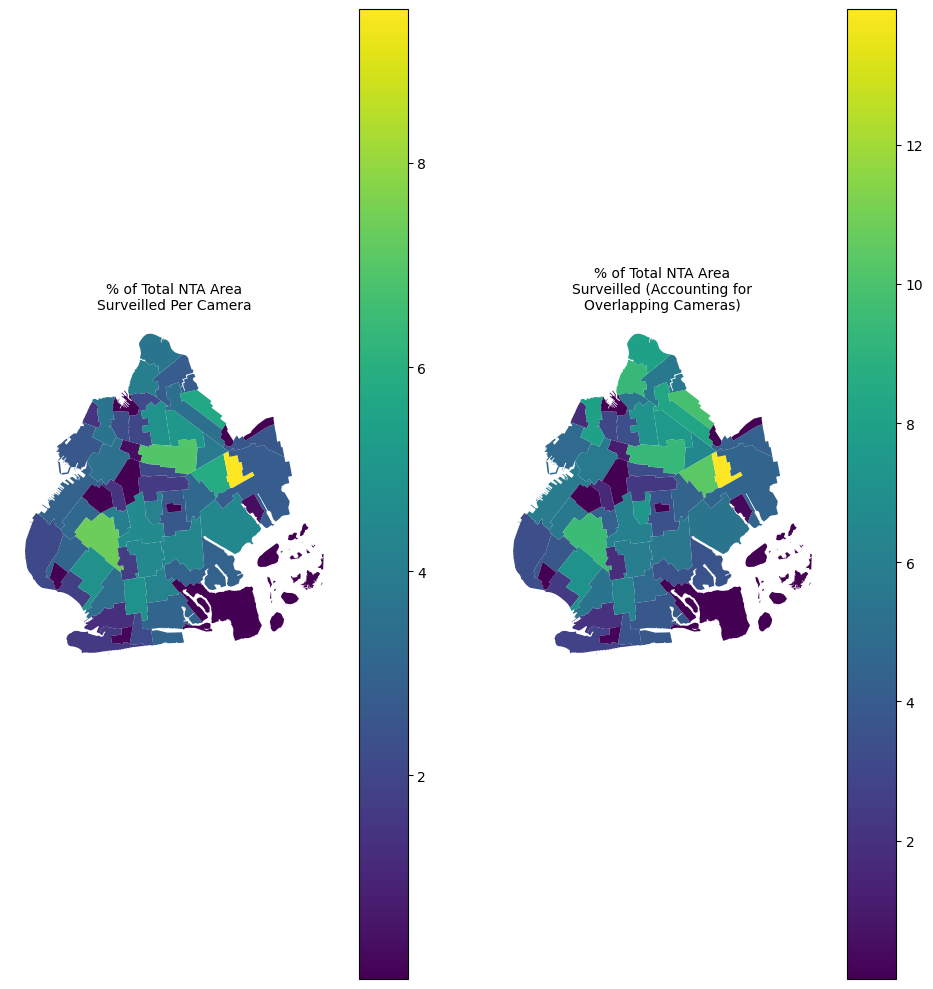

In [73]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
nta_agg.plot(column='Proportion NTA Surveilled (Per Camera)', ax=ax[0], legend=True,
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"})
ax[0].set_title('% of Total NTA Area\nSurveilled Per Camera', fontdict={'fontsize': 10, 'multialignment': 'center'})
nta_agg.plot(column='Proportion NTA Surveilled (All Cameras)', ax=ax[1], legend=True,
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"})
ax[1].set_title('% of Total NTA Area\nSurveilled (Accounting for\nOverlapping Cameras)', 
                 fontdict={'fontsize': 10, 'multialignment': 'center'})
fig.tight_layout()
ax[0].axis('off')
ax[1].axis('off')
plt.show()
# plt.savefig('../Outputs/NTA_BK_CameraBuffer_200m_aggregates.png')

### notes for liz from 04/11 team meeting:

* include street area in denominator not NTA/Tract/Block area..

* Documentation while we do analysis

* color blind accessibility

* can we create a reverse buffer on the BBL shape file to account for surveilling private property

### notes for liz from 04/25 team meeting:

* kernel density estimation to create a function that would represent that 'surface' or surveillance dependent of number of cameras in a given area.

* plot histograms of metrics to get a better sense for surveillance

<Axes: >

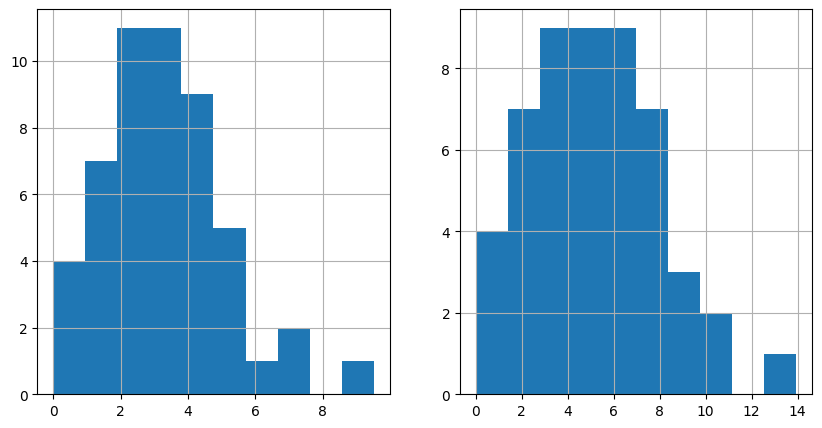

In [78]:
#plot histograms
fig,ax = plt.subplots(1,2,figsize = (10,5))
nta_agg['Proportion NTA Surveilled (Per Camera)'].hist(ax = ax[0])
nta_agg['Proportion NTA Surveilled (All Cameras)'].hist(ax = ax[1])